# Interactive loading of PHOENIX NewEra pickled synthetic stellar spectra
Model grids published in The NewEra model grid ([Hauschildt _et al_., 2025](https://ui.adsabs.harvard.edu/abs/2025arXiv250417597H))

Data and sample code published at [DOI: 10.25592/uhhfdm.16727](https://doi.org/10.25592/uhhfdm.17156).

In [1]:
from pathlib import Path

import numpy as np
from scipy.interpolate import interpn
#%matplotlib widget 
import matplotlib.pyplot as plt

from deblib.constants import c

/home/steveo/projects/main/platodebcat/.platodebcat/lib/python3.11/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


#### Load the previous implementation; numpy array of pickled 1d interpolators
The source NewEra h5 spectra files are located at [https://www.fdr.uni-hamburg.de/record/16738/files/](https://www.fdr.uni-hamburg.de/record/16738/files/).
The set of files for Z=0 are downloaded into `.cache/.newera_spectra` with the `download_newera_spectra.py` module
(at the expense of ~90 GiB disk space).

The module `parse_newera_spectra.py` parses these into a numpy structured array. The fluxes are
published as scipy [`interp1d`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d)
function instances (with `x` based on frequency) in a column named `flux_interp`. The array is saved in a pickle which is loaded here.

In [2]:
# Load the Z==0 table created by parse_newera_spectra.py (either from numpy.save or pkl.dump)
table = np.load("libs/data/newera/PHOENIX-NewEra-LR.Z-0.0.npy", allow_pickle=True)

count_spec = len(table)
teff_from, teff_to = table["teff"].min(), table["teff"].max()
logg_from, logg_to = table["logg"].min(), table["logg"].max()
print(f"Loaded previously built, Z=0 NewEra spectra table containing {count_spec} spectra")
print(f"covering Teff from {teff_from} to {teff_to} K and logg from {logg_from} to {logg_to} dex")

Loaded previously built, Z=0 NewEra spectra table containing 852 spectra
covering Teff from 2300.0 to 12000.0 K and logg from 0.0 to 6.0 dex


#### Load the saved 3d parameter set
Here the same source NewEra h5 spectra files are used and parsed by `newera_spectra_to_interp3d.py`
into a form usable by scipy's [`interpn`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interpn.html)
multidimensional interpolation function.

This is based on axes for $T_{\rm eff}$, $\log{g}$ and freqency with the datapoints being the
flux value. The data are load from the file in 1d arrays named `teffs`, `loggs` and `freqs`,
which are the axes for the data points and the 3d array `V` is the equivalent flux data.

In [3]:
spec_data = np.load(Path("libs/data/newera/PHOENIX-NewEra-for-interp3d.npy.npz"))
points = (spec_data["teffs"], spec_data["loggs"], spec_data["freqs"])
V = spec_data["V"]

## Plot some spectra

In [4]:
# Selection criteria
teff = 6619.5
logg = 4.07
plot_lambdas = np.logspace(np.log10(0.3), np.log10(20), 5000)[:-1]
plot_freq = c*1e6 / plot_lambdas 

Old approach: Select nearest $T_{\rm eff}$ and $\log{g}$ values which gives us an
interp1d for getting fluxes at intermediate frequencies.

In [5]:
# Find the rows with the nearest Teff
teff_best_diff = table[np.argmin(np.abs(table["teff"]-teff))]["teff"] - teff
teff_mask = (table["teff"]+teff_best_diff == teff) | (table["teff"]-teff_best_diff == teff)

# And select the row with the nearest logg
row = table[teff_mask][np.argmin(np.abs(table[teff_mask]["logg"]-logg))]

# Use 1d interpolation to get the fluxes for the chosen frequencies
_fluxes = row["flux_interp"](plot_freq)
vfv = _fluxes * plot_freq
norm_vfv = (vfv - vfv.min()) / (vfv.max() - vfv.min())

New approach: interpolate of 3d parameters space ($T_{\rm eff}$, $\log{g}$, freq)

In [6]:
# We can interpolate for multiple values in one hit;
# in this case we want multiple frequencies for a single Teff/logg combo
xi = np.array([[teff, logg, f] for f in plot_freq])

# Get the fluxes based on a 3d interpolation for the chosen Teff, logg and frequencies (xi)
_fluxes = interpn(points, V, xi, method="linear")
vfv_int = _fluxes * plot_freq
norm_vfv_int = (vfv_int - vfv_int.min()) / (vfv_int.max() - vfv_int.min())

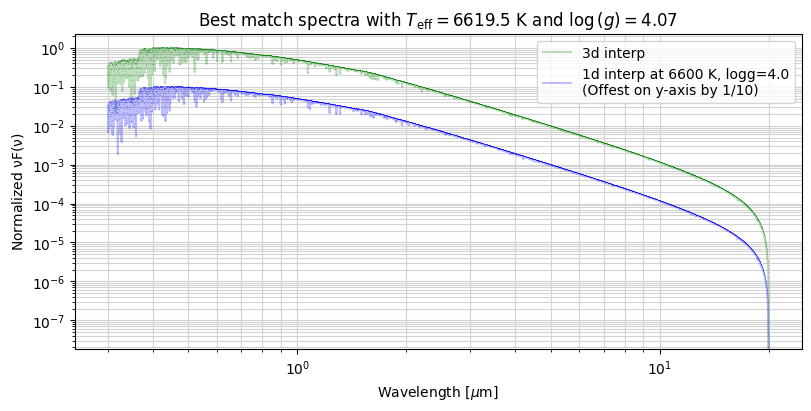

In [7]:
title = f"Best match spectra with $T_{{\\rm eff}}={teff}$ K and $\\log{{(g)}}={logg}$"
fig, ax = plt.subplots(1, 1, figsize=(8, 4), constrained_layout=True)
ax.loglog(plot_lambdas, norm_vfv_int, ",-g", alpha=0.25, label=f"3d interp")
ax.loglog(plot_lambdas, norm_vfv / 10, ",-b", alpha=0.25,
          label=f"1d interp at {row['teff']:.0f} K, logg={row['logg']}\n(Offest on y-axis by 1/10)")
ax.set(title=title, xlabel=r"Wavelength [$\mu$m]", ylabel=r"Normalized ${\rm \nu F(\nu)}$")
ax.grid(True, which="both", axis="both", color="lightgray")
ax.legend(loc="best")
plt.show(fig)
plt.close(fig)